In [134]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [263]:
df_train = pd.read_csv('../data/train_processed.csv')
df_train = df_train[df_train.FULLVAL > 0]
df_val = pd.read_csv("../data/val_processed.csv")


train_y = df_train['FULLVAL'].copy()
val_y = df_val['FULLVAL'].copy()

MIN = 80_000
MAX = 1_600_000

# train_y.loc[train_y > MAX] = MAX
# train_y.loc[train_y < MIN] = MIN

# val_y.loc[val_y > MAX] = MAX
# val_y.loc[val_y < MIN] = MIN

cat_names = df_train.columns[19:]
df_train.drop(columns=['FULLVAL'], inplace=True)
df_val.drop(columns=['FULLVAL'], inplace=True)

train_y_log = np.log(train_y + 1)
val_y_log = np.log(val_y + 1)

In [264]:
df_train[cat_names] = df_train[cat_names].astype('category')
df_val[cat_names] = df_val[cat_names].astype('category')

In [265]:
import xgboost as xgb

dtrain = xgb.DMatrix(df_train.values, enable_categorical=True, label=train_y, feature_names=df_train.columns)
dval = xgb.DMatrix(df_val.values, enable_categorical=True, label=val_y, feature_names=df_val.columns)
results={}

In [266]:
param = {'objective':'reg:squarederror','eval_metric':'rmse', 'verbosity':2, 'nthread':2, "max_depth":6, "eta":0.1}
reg = xgb.train(param,dtrain, 100, evals=[(dval, 'val')], evals_result=results)

[23:43:49] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[0]	val-rmse:6498783.50000
[23:43:49] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[1]	val-rmse:5924799.00000
[23:43:49] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[2]	val-rmse:5415606.50000
[23:43:49] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[3]	val-rmse:4948439.00000
[23:43:49] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[4]	val-rmse:4593669.50000
[23:43:49] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_dep

In [267]:
min(results['val']['rmse'])

999290.1875

In [268]:
y_pred = reg.predict(dval)
#y_pred = np.exp(y_pred)

In [269]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(y_pred, val_y)

151007.29449980598

In [270]:
mean_absolute_error(reg.predict(dtrain), train_y)

87631.19802384193

In [271]:
mean_squared_error(y_pred, val_y, squared=False)

999290.3395463212

In [200]:
relative = pd.Series(np.abs(y_pred - val_y)/(val_y+1))

In [201]:
relative.describe()

count    1765.000000
mean        1.376945
std        15.818454
min         0.000165
25%         0.067970
50%         0.154387
75%         0.331343
max       550.215901
Name: FULLVAL, dtype: float64

In [202]:
bad_val = relative[relative>1].index

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

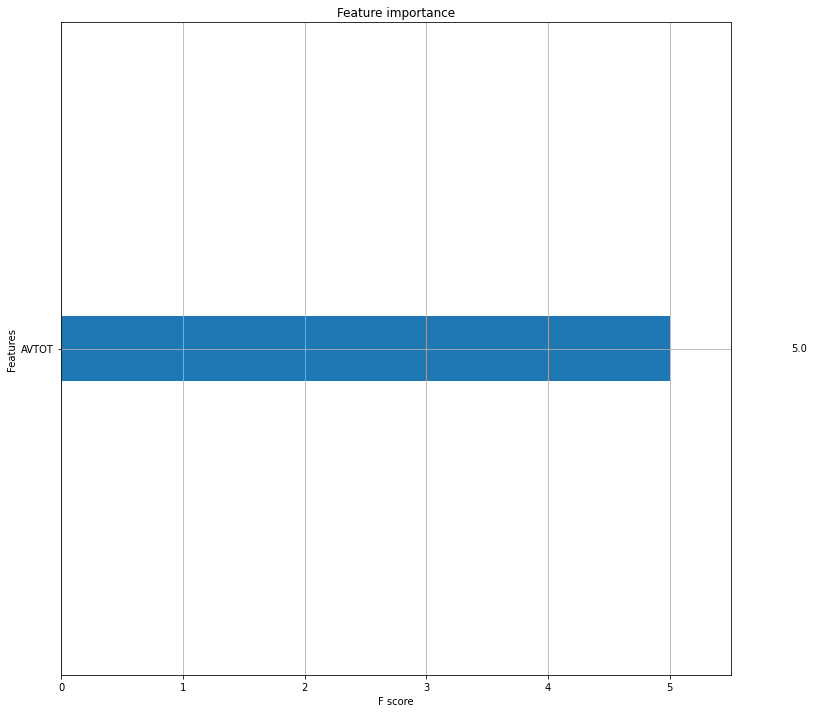

In [211]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
xgb.plot_importance(reg, max_num_features=40)

In [272]:
history = xgb.cv(param, dtrain, num_boost_round=50, nfold=4, stratified=True, metrics='mae', verbose_eval=True, show_stdv=True)

/Users/pawel/.pyenv/versions/3.9.7/envs/bhl/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[23:44:25] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:44:25] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:44:25] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:44:25] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-mae:1216090.59375+88034.25021	test-mae:1221868.28125+272927.84745
[23:44:25] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:44:25] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:44:25] INFO: /Users/runner/work/xgboost/xgboost/sr

<AxesSubplot:>

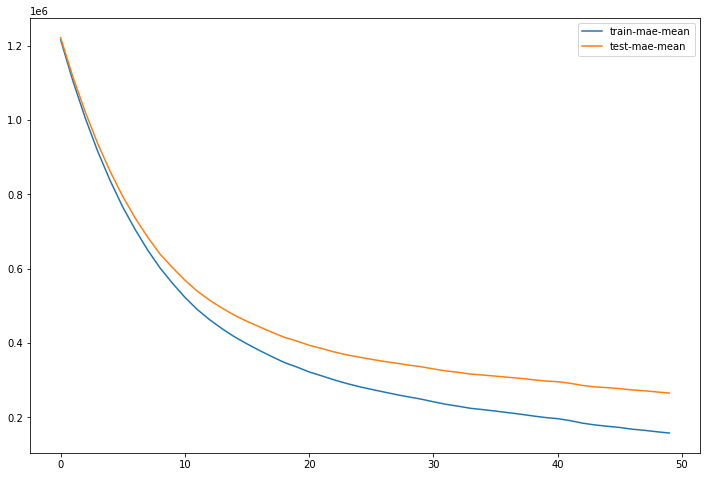

In [273]:
history[['train-mae-mean', 'test-mae-mean']].plot(figsize=(12, 8))

In [176]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(df_train, train_y_log)

In [179]:
y_pred = lin.predict(df_val)

In [180]:
mean_absolute_error(val_y, np.exp(y_pred))

/var/folders/9b/_k13wldd36s0wqcvr1s5hvz40000gn/T/ipykernel_58435/3652206589.py:1: RuntimeWarning: overflow encountered in exp
  mean_absolute_error(val_y, np.exp(y_pred))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

count    1.792000e+03
mean    -4.598239e+06
std      7.413713e+07
min     -1.022836e+09
25%      1.264851e+01
50%      1.320412e+01
75%      1.349330e+01
max      4.827273e+08
dtype: float64